In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn import model_selection
from sklearn import tree
import graphviz
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import optuna

In [2]:
iris = datasets.load_iris()

df = pd.DataFrame(iris.data, columns = iris.feature_names)
df['target'] = iris.target
df['flower_species'] = df.target.apply(lambda x : iris.target_names[x])
print('Unique target values=',df['target'].unique())

df.sample(5)

Unique target values= [0 1 2]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,flower_species
51,6.4,3.2,4.5,1.5,1,versicolor
108,6.7,2.5,5.8,1.8,2,virginica
31,5.4,3.4,1.5,0.4,0,setosa
78,6.0,2.9,4.5,1.5,1,versicolor
114,5.8,2.8,5.1,2.4,2,virginica


In [3]:
X = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
y = df[['target']]

In [4]:
X_train,X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size= 0.2, random_state= 1)

In [5]:
model = tree.DecisionTreeClassifier(random_state= 1)
model.fit(X_train ,y_train)

DecisionTreeClassifier(random_state=1)

In [6]:
model.score(X_test, y_test)

0.9666666666666667

[Text(0.4, 0.9166666666666666, 'x[3] <= 0.8\ngini = 0.665\nsamples = 120\nvalue = [39, 37, 44]'),
 Text(0.3, 0.75, 'gini = 0.0\nsamples = 39\nvalue = [39, 0, 0]'),
 Text(0.35, 0.8333333333333333, 'True  '),
 Text(0.5, 0.75, 'x[3] <= 1.65\ngini = 0.496\nsamples = 81\nvalue = [0, 37, 44]'),
 Text(0.45, 0.8333333333333333, '  False'),
 Text(0.2, 0.5833333333333334, 'x[2] <= 4.95\ngini = 0.18\nsamples = 40\nvalue = [0, 36, 4]'),
 Text(0.1, 0.4166666666666667, 'gini = 0.0\nsamples = 35\nvalue = [0, 35, 0]'),
 Text(0.3, 0.4166666666666667, 'x[0] <= 6.05\ngini = 0.32\nsamples = 5\nvalue = [0, 1, 4]'),
 Text(0.2, 0.25, 'x[3] <= 1.55\ngini = 0.5\nsamples = 2\nvalue = [0, 1, 1]'),
 Text(0.1, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.3, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.4, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.8, 0.5833333333333334, 'x[2] <= 4.85\ngini = 0.048\nsamples = 41\nvalue = [0, 1, 40]'),
 T

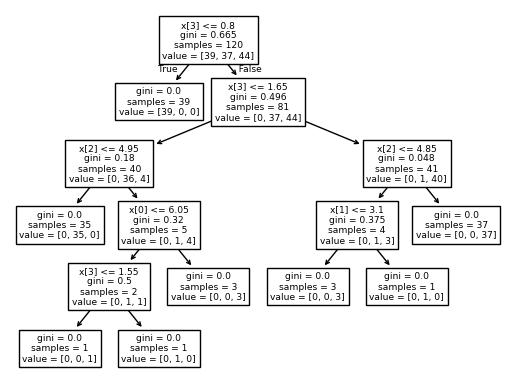

In [7]:
tree.plot_tree(model)

---
<div class="alert alert-block alert-info">
    
**Я переписал код ниже, так как у меня не был скачан `graphviz`**
    
</div>

---

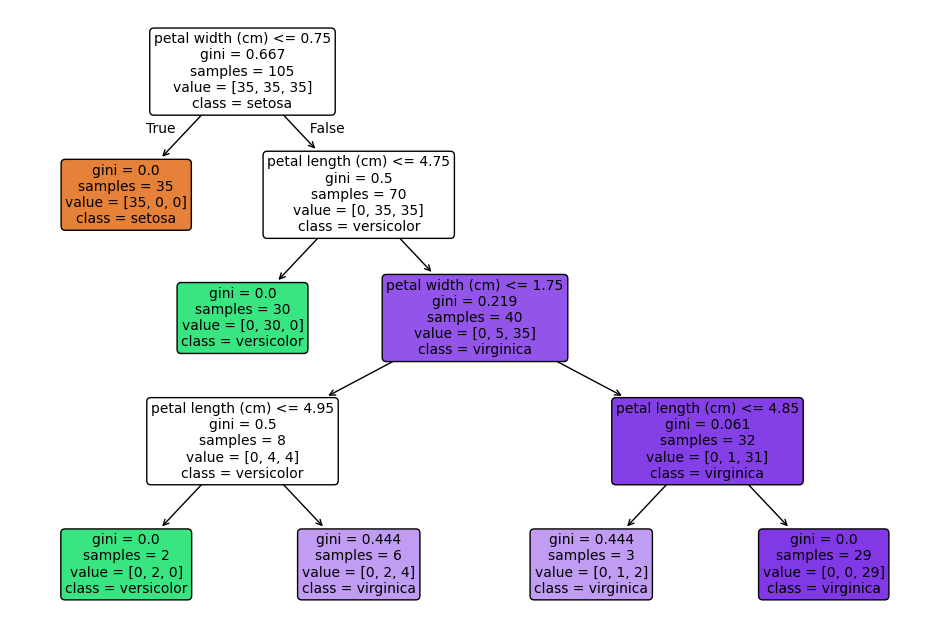

In [9]:
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.3, random_state=1, stratify=iris.target
)

clf = DecisionTreeClassifier(random_state=1, max_depth=4)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(
    clf,
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

# Задача
Подобратьзначения гиперпараметров модели criterion, max_depth, min_samples_leaf с помощью перебора по сетке.

## Сделаю ручным подбором

Зададим сетки гиперпараметров

In [13]:
param_grid = {
    'criterion':        ['gini', 'entropy'],
    'max_depth':        [None, 2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 4, 6]
}

In [14]:
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=1),
    param_grid=param_grid,
    cv=5,              # 5-fold cross-validation
    scoring='accuracy'
)
grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("CV-accuracy:", grid.best_score_)

Лучшие параметры: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4}
CV-accuracy: 0.9333333333333333


Сделаем оценку по выборке

In [16]:
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



## Сделаю через Optuna

Определяем функцию-объектив (to minimize: –accuracy)

In [19]:
def objective(trial):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 6),
        'random_state': 1
    }
    clf = DecisionTreeClassifier(**params)
    #кросс-валидация для надёжности
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    return 1.0 - scores.mean()  # Optuna минимизирует

Запуск оптимизации

In [21]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Лучшие параметры:", study.best_params)
print("CV-accuracy:", 1 - study.best_value)

[I 2025-05-06 13:29:08,230] A new study created in memory with name: no-name-a693fa4b-6a12-4d9a-acb2-9742ffa9d8be
[I 2025-05-06 13:29:08,258] Trial 0 finished with value: 0.05714285714285716 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.05714285714285716.
[I 2025-05-06 13:29:08,287] Trial 1 finished with value: 0.06666666666666665 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.05714285714285716.
[I 2025-05-06 13:29:08,310] Trial 2 finished with value: 0.07619047619047625 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.05714285714285716.
[I 2025-05-06 13:29:08,325] Trial 3 finished with value: 0.06666666666666676 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.05714285714285716.
[I 2025-05-06 13:29:08,342] Trial 4 finished with value: 0.06666

Лучшие параметры: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5}
CV-accuracy: 0.9428571428571428


Оценка на тестовом наборе

In [23]:
best_clf = DecisionTreeClassifier(**study.best_params)
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.93      0.93      0.93        15
   virginica       0.93      0.93      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45

